# Author: Murat C Koc
## Objective: Calculate Shopify Sneaker Stores AOV
## Challenge: Shopify Data Science Internship - Fall 2021

### Question 1:
On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

1. Think about what could be going wrong with our calculation. Think about a better way to evaluate this data. 
2. What metric would you report for this dataset?
3. What is its value?

### Answers:
1. Store_id 78 price per item is 25725 which skew the data. Additionally, automated orders of user_id 607 from store_id 42 with 352 price per item also push the AOV higher values. 
In order to mitigate the effects of extreme outliers, such as store 78 and user_id 607 from the analysis, we need to exclude the store 78 from the data set.

2. Median would be a better metric for that type of skewed data sets.

3. $284.0

### Question 2 answer is at the end of this noteboook

In [251]:
# Libraries
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts

In [252]:
# Read csv into Dataframe
shoe_df = pd.read_csv('https://raw.githubusercontent.com/MuratCKoc/Fall_2021_DataScience_Intern_Challenge/main/data/shopify_sneakers.csv')
shoe_df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


#### Step 1: Check data quality

In [253]:
# Check Null values
if shoe_df.isnull().values.any() == 'False':
    print('NULL DETECTED... Dropping the Nulls')
    shoe_df = shoe_df.dropna(how='any')
else:
    print('Null check passed! No Null values Detected')

Null check passed! No Null values Detected


In [254]:
# Check duplicate entries
shoe_df.duplicated(keep='last')

0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4996    False
4997    False
4998    False
4999    False
Length: 5000, dtype: bool

In [255]:
# Check Data types
shoe_df.dtypes

order_id           int64
shop_id            int64
user_id            int64
order_amount       int64
total_items        int64
payment_method    object
created_at        object
dtype: object

In [256]:
# Convert date types -> created_at
shoe_df['created_at'] = pd.to_datetime(shoe_df['created_at'])
shoe_df.dtypes

order_id                   int64
shop_id                    int64
user_id                    int64
order_amount               int64
total_items                int64
payment_method            object
created_at        datetime64[ns]
dtype: object

#### Step 2: Explore the data

In [257]:
# Lets take a quick look at order_amounts to figure out
shoe_df['order_amount'].describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

#### Problem:
Standard deviation is 41282 where min is only 90 and max is 70400.
Max value needs to be inspected in order to evaluate the data more accurately. Lets see how the data looks like in boxplot

<AxesSubplot:>

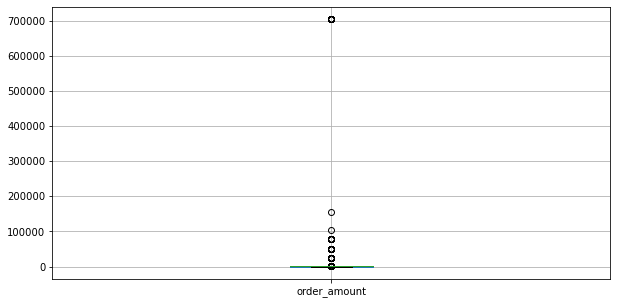

In [258]:
shoe_df.boxplot("order_amount", figsize=(10,5))

It seems like order amount $70400 is the only extreme sale in this dataset. We can calculate outliers to get a better understanding of the set.


In [259]:
shoe_df['item_price'] = shoe_df['order_amount']/shoe_df['total_items']
shoe_df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,item_price
0,1,53,746,224,2,cash,2017-03-13 12:36:56,112.0
1,2,92,925,90,1,cash,2017-03-03 17:38:52,90.0
2,3,44,861,144,1,cash,2017-03-14 04:23:56,144.0
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37,156.0
4,5,18,883,156,1,credit_card,2017-03-01 04:35:11,156.0


#### Inspect the outliers

In [260]:
# Determine if there are any potential outliers in average order_amount
quartiles = shoe_df['item_price'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of item price is: {lowerq}")
print(f"The upper quartile of item price is: {upperq}")
print(f"The interquartile range of item price is: {iqr}")
print(f"The the median of item price is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outlier_order = shoe_df.loc[(shoe_df['item_price'] < lower_bound) | 
                                        (shoe_df['item_price'] > upper_bound)]
outlier_order = outlier_order.reset_index(drop=True)
outlier_order

The lower quartile of item price is: 133.0
The upper quartile of item price is: 169.0
The interquartile range of item price is: 36.0
The the median of item price is: 153.0 
Values below 79.0 could be outliers.
Values above 223.0 could be outliers.


,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,item_price
0,16,42,607,704000,2000,credit_card,2017-03-07 04:00:00,352.0
1,41,42,793,352,1,credit_card,2017-03-24 14:15:41,352.0
2,61,42,607,704000,2000,credit_card,2017-03-04 04:00:00,352.0
3,161,78,990,25725,1,credit_card,2017-03-12 05:56:57,25725.0
4,309,42,770,352,1,credit_card,2017-03-11 18:14:39,352.0
...,...,...,...,...,...,...,...,...
92,4746,42,872,352,1,debit,2017-03-24 00:57:24,352.0
93,4768,42,720,704,2,credit_card,2017-03-14 10:26:08,352.0
94,4869,42,607,704000,2000,credit_card,2017-03-22 04:00:00,352.0
95,4883,42,607,704000,2000,credit_card,2017-03-25 04:00:00,352.0


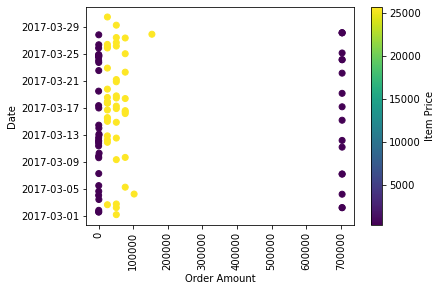

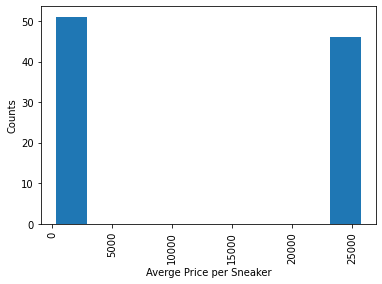

In [261]:
#outlier_shops = shoe_df.loc[(shoe_df['shop_id']=="42") | (shoe_df['shop_id']=="78")]
plt.scatter(outlier_order['order_amount'],outlier_order['created_at'],
c=outlier_order['item_price'])
clb = plt.colorbar()
plt.xlabel("Order Amount")
plt.ylabel("Date")
plt.xticks(rotation=90)
clb.set_label("Item Price")
plt.show()

# Determine if the average item price is normally distributed
plt.hist(outlier_order['item_price'])
plt.xlabel('Averge Price per Sneaker')
plt.xticks(rotation=90)
plt.ylabel('Counts')
plt.show()


- We have 97 outlier orders.
- 352 and 25725 orders belongs to shop 42 and 78 respectively so 78 is obviously is an outlier.
- The shop_id 78 and user_id 607 rides AOV extremely higher points. This issue might be an incorrect pricing, a fraud, location based issues (foreign currency or country taxes), etc. Therefore these store_id 78's operations must be investigated.
- Unknown timeframe of User_id 607's automated bulk orders timed at 04:00 am is also skews the data.

In [262]:
outlier_shops = shoe_df.loc[(shoe_df['user_id'] == 607) ]
outlier_shops.sort_values(['created_at']).value_counts().head()

order_id  shop_id  user_id  order_amount  total_items  payment_method  created_at           item_price
4883      42       607      704000        2000         credit_card     2017-03-25 04:00:00  352.0         1
1603      42       607      704000        2000         credit_card     2017-03-17 04:00:00  352.0         1
61        42       607      704000        2000         credit_card     2017-03-04 04:00:00  352.0         1
521       42       607      704000        2000         credit_card     2017-03-02 04:00:00  352.0         1
1105      42       607      704000        2000         credit_card     2017-03-24 04:00:00  352.0         1
dtype: int64

In [263]:
outlier_shops = shoe_df.loc[(shoe_df['shop_id'] == 78) ]
outlier_shops.sort_values(['created_at']).value_counts().head()

order_id  shop_id  user_id  order_amount  total_items  payment_method  created_at           item_price
4919      78       823      25725         1            cash            2017-03-15 13:26:46  25725.0       1
1420      78       912      25725         1            cash            2017-03-30 12:23:43  25725.0       1
2565      78       915      77175         3            debit           2017-03-25 01:19:35  25725.0       1
2549      78       861      25725         1            cash            2017-03-17 19:36:00  25725.0       1
2513      78       935      51450         2            debit           2017-03-18 18:57:13  25725.0       1
dtype: int64

count    4903.000000
mean      300.155823
std       155.941112
min        90.000000
25%       163.000000
50%       284.000000
75%       386.500000
max      1086.000000
Name: order_amount, dtype: float64
Outlier free data Median: 284.0


<AxesSubplot:>

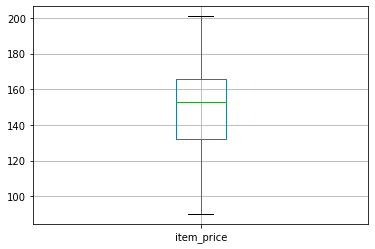

In [264]:
# Outlier free dataset
cleana_df = shoe_df.drop(shoe_df[(shoe_df.item_price < lower_bound) | (shoe_df.item_price > upper_bound)].index)
cleana_df = cleana_df.reset_index(drop=True)
print(cleana_df['order_amount'].describe())
print('Outlier free data Median:',cleana_df['order_amount'].median())
cleana_df.boxplot("item_price")

count      4954.000000
mean       2717.367784
std       41155.996469
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64
Extreme Outliers free data Median: 284.0


<function matplotlib.pyplot.show(close=None, block=None)>

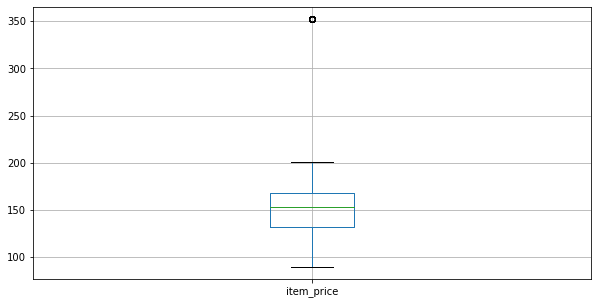

In [265]:
clean_df = shoe_df.drop(shoe_df[(shoe_df.shop_id == 78)].index)
clean_df = clean_df.reset_index(drop=True)
print(clean_df['order_amount'].describe())
print('Extreme Outliers free data Median:',clean_df['order_amount'].median())

clean_df.boxplot("item_price", figsize=(10,5))
plt.show

In [266]:
print(shoe_df['item_price'].describe(),clean_df['item_price'].describe())

count     5000.000000
mean       387.742800
std       2441.963725
min         90.000000
25%        133.000000
50%        153.000000
75%        169.000000
max      25725.000000
Name: item_price, dtype: float64 count    4954.000000
mean      152.475575
std        31.260218
min        90.000000
25%       132.000000
50%       153.000000
75%       168.000000
max       352.000000
Name: item_price, dtype: float64


Pricing metric and strategies vary as the numbers and these numbers seems in a good shape to get better AOV.
Deeper analytics from this dataset might include:
- Top and bottom performing stores
- Foot traffic
- Most valuable customers
- Order type categorization

In [267]:
shopify_AOV = shoe_df['order_amount'].sum() / shoe_df['order_amount'].count()
better_AOV = clean_df['order_amount'].sum() / clean_df['order_amount'].count()
print('Shopfiy AOV:',shopify_AOV)
print('Better AOV:',better_AOV)
print('Median',clean_df['order_amount'].median())

Shopfiy AOV: 3145.128
Better AOV: 2717.3677836092047
Median 284.0


### Question 2:
2a: How many orders were shipped by Speedy Express in total?
Answer: 54 orders shipped by Speedy Express
```sql
SELECT COUNT(ShipperName)
FROM Orders INNER JOIN Shippers ON Orders.ShipperID = Shippers.ShipperID
WHERE ShipperName = 'Speedy Express';
```

2b: What is the last name of the employee with the most orders?
Answer: Peacock
```sql
SELECT Employees.LastName, COUNT(Employees.EmployeeID) as order_count
FROM Employees INNER JOIN Orders ON Orders.EmployeeID = Employees.EmployeeID
GROUP BY LastName
ORDER BY Count(Employees.LastName) DESC
LIMIT 1;
```

2c:What product was ordered the most by customers in Germany?
Answer: 
Boston Crab Meat	160
Gorgonzola Telino	125
Tunnbröd	105
```sql
SELECT  Products.ProductName, SUM(OrderDetails.Quantity)
FROM ((Customers INNER JOIN Orders ON Customers.CustomerID = Orders.CustomerID)
		INNER JOIN OrderDetails ON Orders.OrderID = OrderDetails.OrderID)
		INNER JOIN Products ON OrderDetails.ProductID = Products.ProductID
WHERE Customers.Country = 'Germany'
GROUP BY Products.ProductName
ORDER BY SUM(OrderDetails.Quantity) DESC;
```


